## Introduction

>
>
>
>
>

Hi, and welcome to our CIS 545 Project! 

Our group members are :
- Kelly Liang
- Henry Hung
- Kun Hwi Ko

Today, we are here to do the following :

* Step 1 : Navigate through a movies dataset, and clean for necessary data 
* Step 2 : Visualize the data to get initial insights 
* Step 3 : Reformat the data to be compatible for machine learning 
* Step 4 : Use K-Means Clustering to forecast what movies users will like  

## Packages / Setup

In [214]:
# data cleaning and visualization packages 
!pip install pandasql
import collections 
import numpy as np 
import pandas as pd
import pandasql as ps 
import re 
import matplotlib.pyplot as plt 
import seaborn as sns  

# machine learning packages 
import sklearn


In [ ]:
# Step 1 : install dependencies 
!pip install -q kaggle 

# Step 2 : create API Token from Kaggle and upload Kaggle.json 
# Instructions : https://www.kaggle.com/general/74235
from google.colab import files 
files.upload()


In [ ]:
# Step 3: additional steps 
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 4 : download the dataset 
# https://www.kaggle.com/rounakbanik/the-movies-dataset
!kaggle datasets download -d rounakbanik/the-movies-dataset

# Step 5 : Unzip the files 
!unzip the-movies-dataset.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
User cancelled operation
Archive:  the-movies-dataset.zip
replace credits.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace keywords.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace links_small.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace movies_metadata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ratings_small.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## Data Cleansing

In [197]:
# retrieve Kaggle data 

ratings_df = pd.read_csv("/content/ratings.csv")
keywords_df = pd.read_csv("/content/keywords.csv")
movies_df = pd.read_csv("/content/movies_metadata.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [198]:
# cleansing keywords

# Step 1 : get rid of rows without any keywords 
keywords_df = keywords_df[keywords_df['keywords'] != '[]']

# Step 2 : convert str --> [array of words]
def str_parser(strs):
  res = re.findall("name': '(.*?)'", strs)
  return res if res else None 

keywords_df['keywords'] = keywords_df['keywords'].apply(lambda x : str_parser(x))
keywords_df.dropna(inplace=True)

In [199]:
# cleansing movies

# Step 1 : drop unnecessary columns 
movies_df.drop(columns = ['adult', 'belongs_to_collection', 'budget', 'homepage', \
                          'imdb_id', 'original_language', 'original_title', 'overview', \
                          'poster_path', 'production_countries', 'release_date', 'revenue', \
                          'runtime', 'spoken_languages', 'status', 'tagline', 'video'], inplace = True)

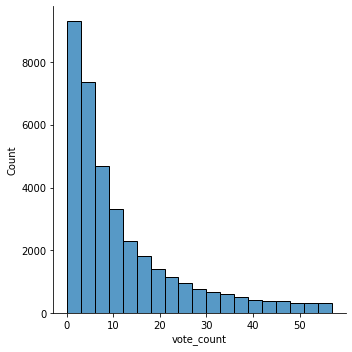

In [200]:
# Step 2: drop movies that not many people have watched as it can create bias 
sns.displot(movies_df, x = "vote_count", bins = [i for i in range(0, 60, 3)])
vote_threshold = 3
movies_df = movies_df[movies_df['vote_count'] >= vote_threshold]

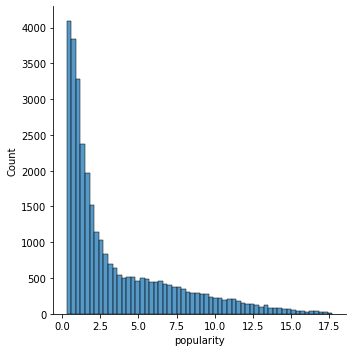

In [201]:
# Step 3: drop non-popular movies as they will likely not be recommended
movies_df['popularity'] = movies_df['popularity'].apply(lambda x : float(x))
sns.displot(movies_df, x = "popularity", bins = [i*0.3 for i in range(1, 60)])
popular_threshold = 0.6
movies_df = movies_df[movies_df['popularity'] >= popular_threshold]

In [202]:
# Step 4 : convert str --> [array of words]
movies_df['genres'] = movies_df['genres'].apply(lambda x : str_parser(x))
movies_df.dropna(inplace=True)

movies_df['production_companies'] = movies_df['production_companies'].apply(lambda x : str_parser(x))
movies_df.dropna(inplace=True)

In [203]:
# join movies_df and keywords_df 
movies_df['genres'] = movies_df['genres'].apply(lambda x : str(x))
movies_df['production_companies'] = movies_df['production_companies'].apply(lambda x : str(x))
keywords_df['keywords'] = keywords_df['keywords'].apply(lambda x : str(x)) 

query = '''
select m.id, title, 
production_companies, genres,
keywords, popularity, 
vote_average, vote_count
from movies_df as m
join keywords_df as k
on m.id = k.id
'''

movies_df = ps.sqldf(query, locals())

In [206]:
# cleansing ratings 

# Step 1 : ratings_df is a very large dataset sorted by userId 
# we do not need to use all of the users as part of training 
ratings_df = ratings_df[ratings_df['userId'] <= 10000]

# Step 2 : drop unnecessary columns 
ratings_df.drop(columns = ['timestamp'], inplace=True) 

In [209]:
# Step 3 : get rid of ratings for movies not in movies_df 

query = '''
select * 
from ratings_df 
where movieId not in (
  select id 
  from movies_df
)
'''

ratings_df = ps.sqldf(query, locals())

In [ ]:
# Step 4 : get rid of movies not rated in ratings_df 
query = '''
select * 
from movies_df 
where id not in (
  select movieId 
  from ratings_df
)
'''

movies_df = ps.sqldf(query, locals())

In [210]:
# Finally convert columns to how we want them 
movies_df['genres'] = movies_df['genres'].apply(lambda x : eval("[" + x[1:-1] + "]")) 
movies_df['production_companies'] = movies_df['production_companies'].apply(lambda x : eval("[" + x[1:-1] + "]")) 
keywords_df['keywords'] = keywords_df['keywords'].apply(lambda x : eval("[" + x[1:-1] + "]"))

## Data Exploration & Visualization

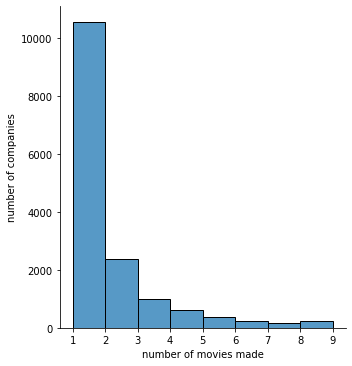

In [211]:
# Is it safe to assume that non-popular production companies didn't make any popular movies?
companies = [company for companies in movies_df['production_companies'] for company in companies]
freq = collections.Counter(companies)

ax = sns.displot(freq, x = freq.values(), bins = [i for i in range(1, 10)])
ax.set(xlabel='number of movies made', ylabel='number of companies')

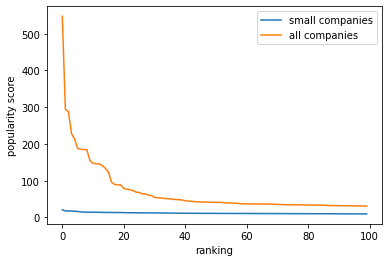

In [212]:
# from the plot above, we can tell there are a lot of companies that have made just 1 movie 
# we now check if any of these companies have produced a movie that turned out to be a success 

large_companies = {k for k,v in freq.items() if v > 1}
number_of_rows = movies_df.count()[0]

popularity_by_small_companies = []
popularity_by_all_companies = []

for i in range(number_of_rows):
  small = True 
  for company in movies_df['production_companies'].iloc[i]:
    if company in large_companies:
      small = False 
      break 
  if small:
    popularity_by_small_companies.append(movies_df['popularity'].iloc[i])
   
plt.plot(sorted(popularity_by_small_companies, reverse=True)[:100], label='small companies')  
plt.plot(sorted(movies_df['popularity'], reverse=True)[:100], label='all companies') 
plt.xlabel('ranking'); plt.ylabel('popularity score')
plt.legend()
      


In [213]:
# note that small companies have never made movies within top 100 in popularity
# however, starting from the 40th most popular movie, there is not a large discrepency 
# to prove that small companies make only non-popular movies 
# therefore, we disregard production companies as a factor for recommending movies 

movies_df.drop(columns = ['production_companies'], inplace=True)